In [0]:
# BitCoin Price Prediction with LSTM RNN

Here, we have


*   Converted 2D data to 3D using matrix algebra
*   Performed Exploratory data analysis
*   Extracted Features
*   Implemented 3 layer LSTM with Fully connected layers.



In [0]:
#Importing Libraries

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, confusion_matrix
import math
import seaborn as sns


## Data Preprocessing

The data is inputed as a .csv file. This method will transform the data from an array of shape (n x m), where n represents the number of rows of data(total number of days) and m represents the number of features relating to bitcoin, to the shape (n-d+1 x d x m), where d (window size) represents the number of days to look at in each sample of data. Here we took  as 50.

The data will then be normalized by looking at each window and dividing each value in the window by the first value of the window and then subtracting one. 

The unnormalized bases are kept in order to get the original values back for the testing data. This is necessary to compare the model's predictions of prices with the true prices.

After normalization, testing data size is kept at 10%. These data will be stored in X_train, Y_train, X_test, and Y_test. 

Finally, a list of the prices before each day Y_test(Y_daybefore) is drawn from will be compiled in order to generate statistics about the model's predictions, including precision, recall, and F1 score. Additionally, these prices can be used to identify whether the model predicted an increase or decrease in price.



In [0]:
def load_data(filename):

    """
    To load bitcoin price prediction data
    
    Inputs:
    filename -> A string that represents where the data file can be located
    
    Outputs:
    data -> Dataframe of bitcoin price prediction data
    """
    
    #Load the data
    data = pd.read_csv(filename)
                
    return data

In [0]:
def data_prepocessing(data, d, train_data_size):
    
    """
    To preproces and split the data to make it ready for training and testing
    
    Input:
    data -> Dataframe of bitcoin price prediction data
    d -> number of days to look at in each sample of data 
    train_data_size -> Size according to which data is splited in training and testing
    
    Output: 
    x_train -> x values of training data
    y_train -> labels of training data
    x_test -> x values of testing data
    y_test -> labels of testing data
    y_daybefore -> the price of bitcoin the day before for each x_test
    unnormalized_labels -> unnormalized label data will be used to get the true prices from the normalized ones
    window_size -> An integer that represents how many days of data the model can look at at once
    
    """
    
    
    #Change all zeros to the number before the zero occurs
    data = data.values
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i][j]==0):
                data[i][j] = data[i-1][j]
                
                
    #convert data to list
    data = data.tolist()
    
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days(n-d+1), b is the window size(d), and c is the number of features in the data file(here 34)
    
    
    data3D = []
    for i in range(len(data)-d):
        data3D.append(data[i : i + d])
    
    #Normalizing data by going through each window as range of features is highly variable
    #Every value in the window is divided by the first value in the window, and then 1 is subtracted
    d1 = np.array(data3D)
    dr = np.zeros_like(d1)
    dr[:,1:,:] = (d1[:,1:,:] / d1[:,0:1,:]) - 1  
    
    #Splitting of data set(eg train_data_size = 0.90, training data is first 90% of data points and testing data last 10% of data points)
    split = round(train_data_size * dr.shape[0])
    #print(split)
    
    #Keeping the unnormalized prices for labels
    #To retrieve unnormalized predicted price of bitcoin later
    start = split-1
    end = int(dr.shape[0] + 1)
    unnormalized_labels = d1[start:end,0:1,20]
    
    #Training Data
    train_data = dr[:int(split), :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1]
    y_train = y_train[:, 20]
    
    #print(x_train.shape)
    #print(x_train)

    #print(y_train.shape)
    #print(y_train)
    
    
    #Testing data
    x_test = dr[int(split):, :-1]
    y_test = dr[int(split):, d-1, :]
    y_test = y_test[:, 20]

    #print(x_test.shape)
    #print(x_test)

    #print(y_test.shape)
    #print(y_test)

    #Get the day before price for each x_test
    y_daybefore = dr[int(split):, d-2, :]
    y_daybefore = y_daybefore[:, 20]

    #print(y_daybefore)
    
    #Get window size and sequence length
    sequence_length = d
    window_size = sequence_length-1 #last value is reserved as the y value
    
    return x_train, y_train, x_test, y_test, y_daybefore, unnormalized_labels, window_size

# Building the Model

The model to be used in this project is a three-layer recurrent neural network (RNN) that incorporates dense layer at each layer with linear activation function. 

The model uses the AdamOptimizer as its optimization function.

The loss function used in this model is mean squared error. 

A linear activation function is used in this model to determine the output of each neuron in the model. 
The model will use Keras's Sequential model with LSTM layers.

In [0]:
def model(window_size, dropout_value, activation_function, loss_function, optimizer):
    
    """
    To initialize and create model
    
    Input:
    window_size -> Represents how many days of data the model can look at at once
    dropout_value -> Represents how much dropout should be incorporated at each level
    activation_function -> Activation function 
    loss_function -> Loss function 
    optimizer -> Optimizer 
    
    Output:
    model -> A 3 layer RNN with dense layer in each layer
    """
    
    #Create a Sequential model using Keras
    model = Sequential()

    #First recurrent layer with dropout
    model.add(LSTM(window_size, return_sequences=True, input_shape=(window_size, N_x_train.shape[-1]),))
    model.add(Dense(units=64,activation=activation_function))
    
    #Second recurrent layer with dropout
    model.add(LSTM((window_size*2), return_sequences=True))
    model.add(Dense(units=32,activation=activation_function))

    #Third recurrent layer
    model.add(LSTM(window_size, return_sequences=False))

    #Output layer (returns the predicted value)
    model.add(Dense(units=1, activation=activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model
  

# Testing the Model

The model will be given the x values of the testing data and will make predictions of the normalized prices. This will be stored as N_y_predict(Normalized Predicted price)

Then, both the predicted values and the actual values (N_y_predict and N_y_test) will be unnormalized and stored in seperate arrays. The values are unnormalized by the unnormalization processs i.e the exact reverse of the normalization process

Finally, a plot is created of the unnormalized real values and the unnormalized predicted values. The plot represents bitcoin price over time, and the predicted values are represented by a green line, whereas the real values are represented by a red line. The x axis represents time in days and the y axis represents bitcoin price in US dollars.

In [0]:
def test_model(model, N_x_test, N_y_test, unnormalized_labels):
  
    """
    For model Testing
    
    Input:
    model -> LSTM
    N_x_test -> Normalized x values of the testing data
    N_y_test -> Normalized labels of the testing data
    unnormalized_labels -> unnormalized label data will be used to get the true prices from the normalized ones
    
    Output:
    N_y_predict -> Normalized predicted values on x_test
    y_test -> Unnormalized actual prices of bitcoin throughout the testing period
    y_predict -> Unnormalized predicted prices of bitcoin
    fig -> graph of the predicted prices vs the actual prices of bitcoin
    """
    
    #Test the model on Normalized x_test
    N_y_predict = model.predict(N_x_test)
    
    #Retrieve unnormalized values
    y_test = np.zeros_like(N_y_test)
    y_predict = np.zeros_like(N_y_predict)
    
    for i in range(N_y_test.shape[0]):
        y = N_y_test[i]
        predict = N_y_predict[i]
        y_test[i] = (y+1)*unnormalized_labels[i]
        y_predict[i] = (predict+1)*unnormalized_labels[i]

    #Plot of the predicted prices versus the actual prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Price Over Time")
    plt.plot(y_predict, color = 'green', label = 'Predicted Price')
    plt.plot(y_test, color = 'red', label = 'Actual Price')
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    plt.show()
    
    return N_y_predict, y_test, y_predict, fig

# Changes in Price
This cell will plot the model's predicted change in price each day against the actual change in price each day and then graphed together to visualize the difference between the two for bitcoin throughout the testing period. 

The plot will represent the percent change in bitcoin price each day. A green line will represent the predicted percent change, while a red line will represent the true percent change. The x axis is time in days, while the y value is percent change in bitcoin price.

In [0]:
def price_change(N_y_daybefore, N_y_test, N_y_predict):
    
    """
    Calculate the percent change between each value and the day before
    
    Input:
    y_test -> Normalized labels of the testing data
    y_daybefore -> Normalized price of bitcoin the day before for each x_test
    y_predict -> Normalized predicted values on x_test
    
    Output:
    N_y_test -> Normalized labels of the testing data
    N_y_daybefore -> the price of bitcoin the day before for each x_test
    delta_predict -> Represents the difference between predicted(y_predict) and day before price(y_daybefore) of bitcoin
    delta_test -> Represents the difference between actual(y_test) and day before price(y_daybefore) of bitcoin
    fig -> A plot representing percent change in bitcoin price per day
    
    """
    
    #Reshaping Y_daybefore and Y_test
    N_y_daybefore = np.reshape(N_y_daybefore, (-1, 1))
    N_y_test = np.reshape(N_y_test, (-1, 1))

    #The difference between each predicted value and the value from the day before
    delta_predict = (N_y_predict - N_y_daybefore) / (1+N_y_daybefore)

    #The difference between each true value and the value from the day before
    delta_test = (N_y_test - N_y_daybefore) / (1+N_y_daybefore)
    
    #Plotting the predicted percent change versus the actual percent change
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title("Percent Change in Bitcoin Price Per Day")
    plt.plot(delta_predict, color='green', label = 'Predicted Percent Change')
    plt.plot(delta_test, color='red', label = 'Actual Percent Change')
    plt.ylabel("Percent Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    
    return delta_predict, delta_test, fig

# Percent Change in Price# 
The percent change in price will be processsed such that an increase in price is represented by 1, and a decrease/no change is represented by a 0. These binary values will be stored in arrays delta_predict_binary and delta_test_binary.

This will be done by looping through the values of the actual and predicted percent change arrays. If a value is greater than 0, 1 is stored in a new array. Otherwise, a 0 is stored in the new array.

In [0]:
def binary_price(delta_predict, delta_test):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change in bitcoin price
    
    Input:
    delta_predict -> Represents the predicted percent change in price
    delta_test -> Represents the actual percent change in price
    
    Output:
    delta_predict_binary -> Represents if predicted price increase or decrease wrt day before
    delta_test_binary -> Represents if actual price increase or decrease wrt day before
    """
    
    #Empty arrays where 1 represents an increase in price and 0 represents a decrease in price
    delta_predict_binary = np.empty(delta_predict.shape)
    delta_test_binary = np.empty(delta_test.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(delta_predict.shape[0]):
        if delta_predict[i][0] > 0:
            delta_predict_binary[i][0] = 1
        else:
            delta_predict_binary[i][0] = 0
    for i in range(delta_test.shape[0]):
        if delta_test[i][0] > 0:
            delta_test_binary[i][0] = 1
        else:
            delta_test_binary[i][0] = 0    

    return delta_predict_binary, delta_test_binary

# Confusion Matrix
The binary categories computed in the previous cell is now used to compare predicted and actual data. It will be used to find the number of:

True positives
False positives
True negatives
False negatives 
These can then be used to further calculate statistics of the model's performance.

In [0]:
def find_positives_negatives(delta_predict_binary, delta_test_binary):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Input: 
    delta_predict_binary -> Represents if predicted price increase or decrease wrt day before
    delta_test_binary -> Represents if actual price increase or decrease wrt day before
    
    Output:
    true_pos -> Represents the number of true positives achieved by the model
    false_pos -> Represents the number of false positives achieved by the model
    true_neg -> Represents the number of true negatives achieved by the model
    false_neg -> Represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(delta_test_binary.shape[0]):
        test = delta_test_binary[i][0]
        predicted = delta_predict_binary[i][0]
        if test == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif test == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

In [0]:
def calculate_statistics(true_pos, false_pos, true_neg, false_neg, N_y_predict, N_y_test):
    """
    Calculate various statistics to assess performance
    
    Input:
    true_pos -> Represents the number of true positives achieved by the model
    false_pos -> Represents the number of false positives achieved by the model
    true_neg -> Represents the number of true negatives achieved by the model
    false_neg -> Represents the number of false negatives achieved by the model
    N_y_test -> Normalized labels of the testing data
    N_y_predict -> Normalized predicted values on x_test
    
    Output:
    precision -> How many selected items are relevent? (TP/TP+FP)
    recall -> How many relevent items are selected? (TP/TP+FN)
    F1 -> The weighted average of recall and precision
    Mean Squared Error -> The average of the squares of the differences between predicted and actual bitcoin price
    
    """
    
    precision = float(true_pos) / (true_pos + false_pos)
    recall = float(true_pos) / (true_pos + false_neg)
    F1 = float(2 * precision * recall) / (precision + recall)
    MSE = mean_squared_error(N_y_predict.flatten(), N_y_test.flatten())
    RMSE = math.sqrt(MSE)

    return precision, recall, F1, MSE, RMSE

# Implementing it all

In [46]:
# Loading dataset

data = load_data("Bitcoin_Price_Prediction_data.csv")

# Analysis of data
# Exploratory data analysis
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 35 columns):
Annual Hash Growth        2717 non-null float64
Block Height              2717 non-null int64
Block Interval            2717 non-null int64
Block Size                2717 non-null int64
Blockchain Size           2717 non-null int64
Daily Blocks              2717 non-null int64
Chain Value Density       2717 non-null float64
Daily Transactions        2717 non-null int64
Difficulty                2717 non-null int64
Fee Percentage            2717 non-null float64
Two-Week Hash Growth      2717 non-null float64
Hash Rate                 2717 non-null float64
Market Capitalization     2717 non-null float64
Metcalfe's Law - TX       2717 non-null float64
Metcalfe's Law - UTXO     2717 non-null float64
Miner Revenue Value       2717 non-null float64
Miner Revenue             2717 non-null float64
Money Supply              2717 non-null float64
Output Value              2717 non-null flo

,Annual Hash Growth,Block Height,Block Interval,Block Size,Blockchain Size,Daily Blocks,Chain Value Density,Daily Transactions,Difficulty,Fee Percentage,Two-Week Hash Growth,Hash Rate,Market Capitalization,Metcalfe's Law - TX,Metcalfe's Law - UTXO,Miner Revenue Value,Miner Revenue,Money Supply,Output Value,Output Volume,Bitcoin Price,Quarterly Hash Growth,Total Transactions,Transaction Amount,Transaction Fees,Transaction Size,Transaction Value,Transactions per Block,Avg. UTXO Amount,UTXO Growth,UTXO Set Size,Avg. UTXO Value,Velocity - Daily,Velocity - Quarterly,Velocity of Money
0,58400.8,68784,491,805,22309312,173,8082.42,421,182,0.000306,847.195,0.001624,171960.0,0.45,0.18,432.51,8650.13,3439200.0,2121.67,42433.39,0.05,1863.75,87090,53.737609,0.13,207,2.69,2,59.8091,-18,57503,2.99,0.012338,1.55252,1.85198
1,66500.5,68956,480,796,22446201,172,12885.14,420,182,0.004067,969.128,0.001816,275824.0,0.73,0.29,688.06,8600.79,3447800.0,1553.87,19423.36,0.08,2052.74,87510,39.314915,0.79,201,3.15,2,59.9305,27,57530,4.79,0.005634,1.54743,1.85299
2,72133.5,69130,494,800,22585455,174,14442.76,508,182,0.000112,1011.560,0.001929,311085.0,0.65,0.33,783.00,8700.05,3456500.0,4007.25,44525.04,0.09,2161.81,88018,68.669877,0.05,207,6.18,3,59.9036,171,57701,5.39,0.012882,1.55222,1.86121
3,70182.8,69311,477,1091,22782880,181,12760.08,604,182,0.000000,981.530,0.001942,277244.0,0.48,0.29,724.00,9050.00,3465550.0,2510.90,31386.29,0.08,2006.80,88622,47.422645,0.00,242,3.79,3,59.8954,159,57860,4.79,0.009057,1.55488,1.86366
4,70460.4,69518,418,604,22907871,207,12728.36,454,182,0.000000,1015.060,0.002024,278072.0,0.66,0.29,828.00,10350.00,3475900.0,2166.56,27082.02,0.08,2093.14,89076,52.743441,0.00,196,4.22,2,59.9293,140,58000,4.79,0.007791,1.55180,1.86590


# Analysis of Data

In [47]:
data.describe()

,Annual Hash Growth,Block Height,Block Interval,Block Size,Blockchain Size,Daily Blocks,Chain Value Density,Daily Transactions,Difficulty,Fee Percentage,Two-Week Hash Growth,Hash Rate,Market Capitalization,Metcalfe's Law - TX,Metcalfe's Law - UTXO,Miner Revenue Value,Miner Revenue,Money Supply,Output Value,Output Volume,Bitcoin Price,Quarterly Hash Growth,Total Transactions,Transaction Amount,Transaction Fees,Transaction Size,Transaction Value,Transactions per Block,Avg. UTXO Amount,UTXO Growth,UTXO Set Size,Avg. UTXO Value,Velocity - Daily,Velocity - Quarterly,Velocity of Money
count,2.717000e+03,2717.000000,2717.000000,2.717000e+03,2.717000e+03,2717.000000,2.717000e+03,2717.000000,2.717000e+03,2717.000000,2717.000000,2.717000e+03,2.717000e+03,2717.000000,2717.000000,2.717000e+03,2717.000000,2.717000e+03,2.717000e+03,2.717000e+03,2717.000000,2717.000000,2.717000e+03,2717.000000,2717.000000,2717.000000,2717.000000,2717.000000,2717.000000,2.717000e+03,2.717000e+03,2717.000000,2717.000000,2717.000000,2717.000000
mean,2.322256e+05,290121.020979,552.229297,3.596496e+05,3.605542e+10,159.052264,1.957698e+05,105047.054104,1.435442e+11,0.003429,17.498592,1.073417e+06,1.111097e+10,7.997361,3.521818,1.895088e+06,4962.777531,1.187311e+07,1.630517e+09,1.638278e+06,703.395410,330.305712,6.906763e+07,59.284233,57.049706,559.639308,7306.077847,690.444976,9.029398,2.407870e+04,1.851563e+07,340.658230,0.133000,11.521119,41.651006
std,8.136621e+05,123856.257797,81.273983,3.456604e+05,4.235361e+10,25.487620,2.448978e+05,102103.184410,3.014149e+11,0.004723,57.197651,2.276539e+06,3.018443e+10,10.828318,4.510033,4.496178e+06,2527.385820,3.756902e+06,5.079428e+09,2.403121e+06,1804.877101,788.729427,7.989892e+07,133.479992,102.864154,288.406910,15851.573664,680.709706,19.093193,8.633611e+04,1.917731e+07,524.635632,0.203740,9.272775,25.316069
min,1.685260e+00,68784.000000,281.000000,4.160000e+02,2.230931e+07,80.000000,7.596650e+03,268.000000,1.820000e+02,0.000000,-22.694100,1.624375e-03,1.719600e+05,0.060000,0.180000,3.000000e+02,1242.089114,3.439200e+06,5.507600e+02,9.179250e+03,0.050000,-43.250200,8.709000e+04,3.541134,0.000000,173.000000,1.470000,1.000000,0.256000,-3.427100e+05,5.750300e+04,2.990000,0.002380,1.271430,1.851980
25%,2.252150e+02,181737.000000,505.000000,6.484400e+04,1.489622e+09,143.000000,4.928990e+04,21643.000000,1.755425e+06,0.001134,1.992940,1.268793e+01,8.423734e+07,1.870000,0.900000,6.156356e+04,3424.779927,9.086850e+06,1.411304e+07,5.634196e+05,10.130000,20.106600,3.485076e+06,9.453327,11.198077,468.000000,810.030000,139.000000,0.428100,1.159000e+03,1.608384e+06,47.360000,0.052788,5.642680,22.576300
50%,6.311270e+02,294425.000000,554.000000,2.135200e+05,1.737656e+10,155.000000,1.188306e+05,65151.000000,6.119726e+09,0.001979,8.164480,4.608093e+04,3.463027e+09,4.390000,1.870000,9.208511e+05,4112.633405,1.261062e+07,2.406031e+08,1.157203e+06,241.840000,57.181000,3.630288e+07,14.935804,22.341705,551.000000,2882.090000,393.000000,1.248000,8.605000e+03,1.010484e+07,185.080000,0.090218,9.815180,36.825600
75%,4.446210e+04,398312.000000,600.000000,6.826520e+05,5.938246e+10,170.000000,2.113238e+05,191044.000000,1.440000e+11,0.003807,19.324300,1.111552e+06,8.129470e+09,7.800000,3.810000,1.871826e+06,6977.537648,1.520780e+07,1.015526e+09,2.095208e+06,599.770000,252.778000,1.099182e+08,59.938841,50.753886,637.000000,6239.550000,1228.000000,5.649700,2.868100e+04,3.536452e+07,348.070000,0.149465,13.972300,58.382100
max,7.581090e+06,500756.000000,1075.000000,1.072239e+06,1.500000e+11,307.000000,2.269798e+06,498327.000000,1.870000e+12,0.077918,1047.800000,1.440592e+07,3.210000e+11,93.950000,38.670000,5.428315e+07,15371.520740,1.675945e+07,5.803795e+10,6.736750e+07,19193.720000,6510.710000,2.868851e+08,2599.832838,1495.748916,10009.000000,212776.090000,2724.000000,72.698700,1.761473e+06,6.547875e+07,5053.710000,4.454840,52.894300,94.544600


In [48]:
# Checking null values

data.apply(lambda x : sum(x.isnull()), axis=0)

#no null value found

Annual Hash Growth        0
Block Height              0
Block Interval            0
Block Size                0
Blockchain Size           0
Daily Blocks              0
Chain Value Density       0
Daily Transactions        0
Difficulty                0
Fee Percentage            0
Two-Week Hash Growth      0
Hash Rate                 0
Market Capitalization     0
Metcalfe's Law - TX       0
Metcalfe's Law - UTXO     0
Miner Revenue Value       0
Miner Revenue             0
Money Supply              0
Output Value              0
Output Volume             0
Bitcoin Price             0
Quarterly Hash Growth     0
Total Transactions        0
Transaction Amount        0
Transaction Fees          0
Transaction Size          0
Transaction Value         0
Transactions per Block    0
Avg. UTXO Amount          0
UTXO Growth               0
UTXO Set Size             0
Avg. UTXO Value           0
Velocity - Daily          0
Velocity - Quarterly      0
Velocity of Money         0
dtype: int64

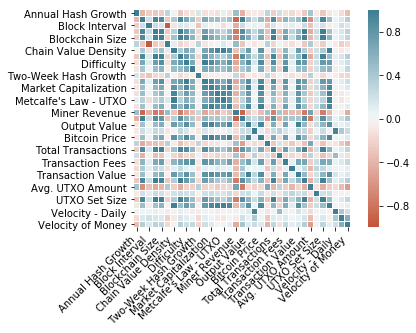

In [49]:
# Correlational Matrix

corr = data.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, linewidths = 0.005)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Saving correlational matrix as image
plt.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)

# Market Capitalization and Output Value are highly correlated with Bitcoin Price

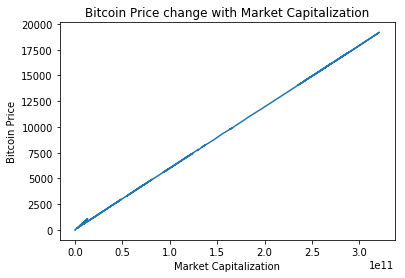

In [50]:
# How Bitcoin Price change with Market Capitalization

x = data['Market Capitalization']
y = data['Bitcoin Price']
plt.title("Bitcoin Price change with Market Capitalization")
plt.xlabel("Market Capitalization")
plt.ylabel("Bitcoin Price")
plt.plot(x,y)


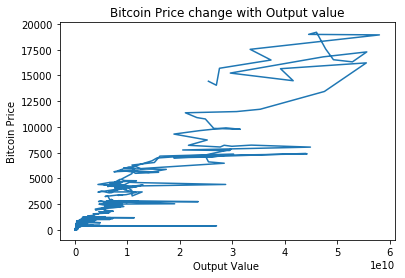

In [51]:
# How Bitcoin Price change with dollar value of all outputs sent over the network

x = data['Output Value']
y = data['Bitcoin Price']
plt.title("Bitcoin Price change with Output value")
plt.xlabel("Output Value ")
plt.ylabel("Bitcoin Price")
plt.plot(x,y)

Text(0.5, 1.0, 'Bitcoin Price')

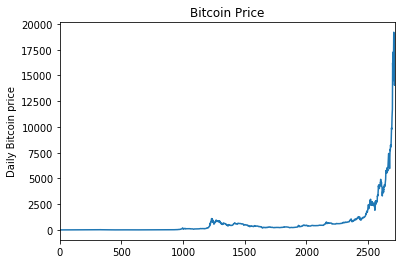

In [52]:
data['Bitcoin Price'].plot()
plt.ylabel("Daily Bitcoin price")
plt.title("Bitcoin Price")

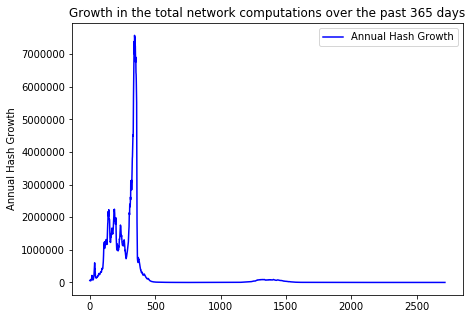

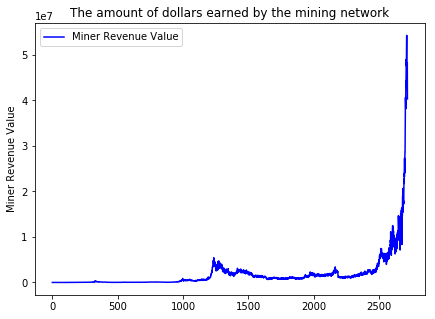

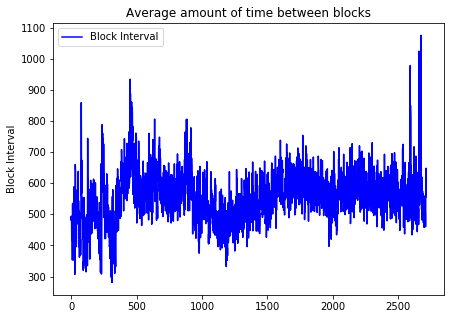

In [53]:
# Growth in the total network computations over the past 365 days
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_subplot(111)
ax1.set_title("Growth in the total network computations over the past 365 days")
x = data['Annual Hash Growth']
plt.plot(x, color='b', label = 'Annual Hash Growth')
plt.ylabel("Annual Hash Growth")
ax1.legend()
plt.show()
    
#The amount of dollars earned by the mining network
fig = plt.figure(figsize=(7, 5))
ax2 = fig.add_subplot(111)
ax2.set_title("The amount of dollars earned by the mining network")
x = data['Miner Revenue Value']
plt.plot(x, color='b', label = 'Miner Revenue Value')
plt.ylabel("Miner Revenue Value")
ax2.legend()
plt.show()

#Average amount of time between blocks
fig = plt.figure(figsize=(7, 5))
ax2 = fig.add_subplot(111)
ax2.set_title("Average amount of time between blocks")
x = data['Block Interval']
plt.plot(x, color='b', label = 'Block Interval')
plt.ylabel("Block Interval")
ax2.legend()
plt.show()
    

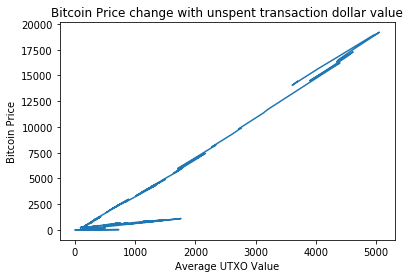

In [54]:

# How Bitcoin Price changes with unspent transaction dollar value

x = data['Avg. UTXO Value']
y = data['Bitcoin Price']
plt.title("Bitcoin Price change with unspent transaction dollar value")
plt.xlabel("Average UTXO Value")
plt.ylabel("Bitcoin Price")
plt.plot(x,y)

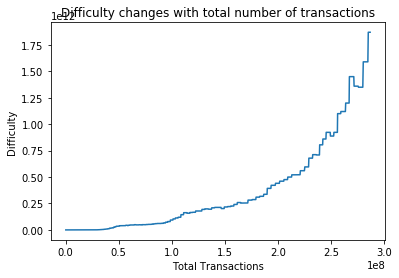

In [55]:
# How Difficulty changes with total number of transactions

x = data['Total Transactions']
y = data['Difficulty']
plt.title("Difficulty changes with total number of transactions")
plt.xlabel("Total Transactions")
plt.ylabel("Difficulty")
plt.plot(x,y)

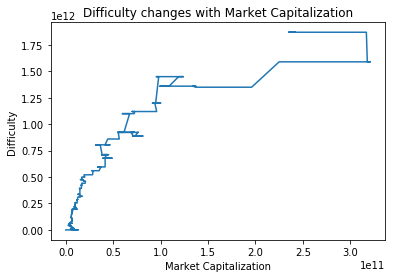

In [56]:
# How Difficulty changes with Market Capitalization

x = data['Market Capitalization']
y = data['Difficulty']
plt.title("Difficulty changes with Market Capitalization")
plt.xlabel("Market Capitalization")
plt.ylabel("Difficulty")
plt.plot(x,y)

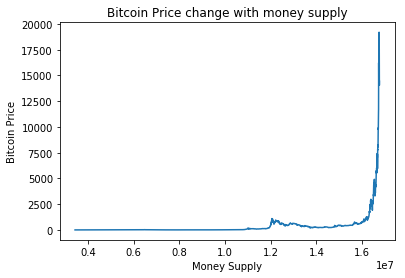

In [57]:

# How Bitcoin Price change with money supply

x = data['Money Supply']
y = data['Bitcoin Price']
plt.title("Bitcoin Price change with money supply")
plt.xlabel("Money Supply")
plt.ylabel("Bitcoin Price")
plt.plot(x,y)

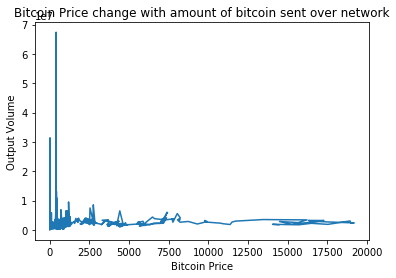

In [58]:
# How Bitcoin Price change with amount of bitcoin sent over network

y = data['Output Volume']
x = data['Bitcoin Price']
plt.title("Bitcoin Price change with amount of bitcoin sent over network")
plt.ylabel("Output Volume")
plt.xlabel("Bitcoin Price")
plt.plot(x,y)

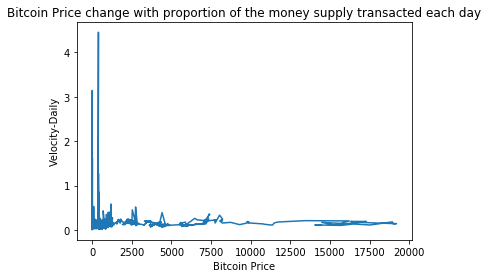

In [59]:
# How Bitcoin Price changes with proportion of the money supply transacted each day

y = data['Velocity - Daily']
x = data['Bitcoin Price']
plt.title("Bitcoin Price change with proportion of the money supply transacted each day")
plt.ylabel("Velocity-Daily")
plt.xlabel("Bitcoin Price")
plt.plot(x,y)

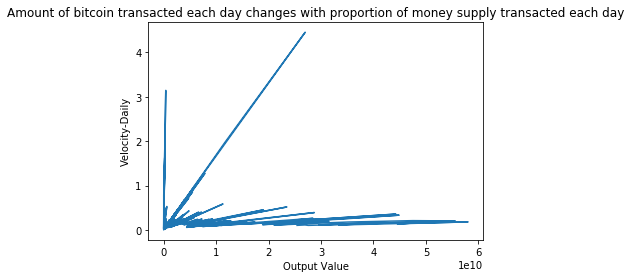

In [60]:
# How amount of bitcoin transacted each day changes with proportion of money supply transacted each day 

y = data['Velocity - Daily']
x = data['Output Value']
plt.title("Amount of bitcoin transacted each day changes with proportion of money supply transacted each day")
plt.ylabel("Velocity-Daily")
plt.xlabel("Output Value")
plt.plot(x,y)

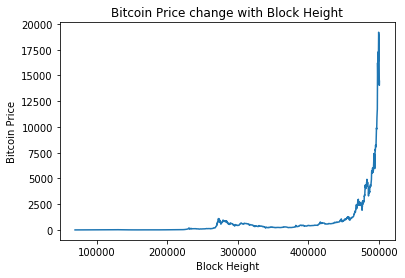

In [61]:
# How Bitcoin Price changes with number of blocks

x = data['Block Height']
y = data['Bitcoin Price']
plt.title("Bitcoin Price change with Block Height")
plt.xlabel("Block Height")
plt.ylabel("Bitcoin Price")
plt.plot(x,y)

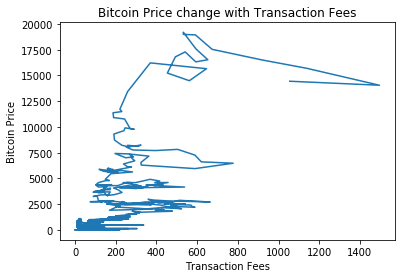

In [62]:
# How Bitcoin Price changes with Transaction Fees

x = data['Transaction Fees']
y = data['Bitcoin Price']
plt.title("Bitcoin Price change with Transaction Fees")
plt.xlabel("Transaction Fees")
plt.ylabel("Bitcoin Price")
plt.plot(x,y)

In [63]:
#Data Preprocessing for training and testing of data

N_x_train, N_y_train, N_x_test, N_y_test, N_y_daybefore, unnormalized_labels, window_size = data_prepocessing(data, 50, 0.90)
print (N_x_train.shape)
print (N_y_train.shape)
print (N_x_test.shape)
print (N_y_test.shape)
print (N_y_daybefore.shape)
print (unnormalized_labels.shape)
print (window_size)

(2400, 49, 35)
(2400,)
(267, 49, 35)
(267,)
(267,)
(268, 1)
49


# Initializing the Model

In [64]:
#Model Initialization

model = model(window_size, 0.2, 'linear', 'mse', 'adam')
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 49, 49)            16660     
_________________________________________________________________
dense_4 (Dense)              (None, 49, 64)            3200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 49, 98)            63896     
_________________________________________________________________
dense_5 (Dense)              (None, 49, 32)            3168      
_________________________________________________________________
lstm_6 (LSTM)                (None, 49)                16072     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 50        
Total params: 103,046
Trainable params: 103,046
Non-trainable params: 0
_________________________________________________________________
None

# Training

In [65]:
start = time.time()

#Train the model on training data 
model.fit(N_x_train, N_y_train, batch_size= 1024, epochs=50, validation_split= 0.1)

#Get the time it took to train the model (in seconds)
training_time = int(math.floor(time.time() - start))

print("Training Time :", training_time)

Train on 2160 samples, validate on 240 samples
Epoch 1/50
2160/2160 [==============================] - 6s 3ms/step - loss: 3.2261 - val_loss: 0.0253
Epoch 2/50
2160/2160 [==============================] - 3s 1ms/step - loss: 2.6498 - val_loss: 0.2071
Epoch 3/50
2160/2160 [==============================] - 3s 1ms/step - loss: 2.2011 - val_loss: 0.3844
Epoch 4/50
2160/2160 [==============================] - 3s 1ms/step - loss: 1.9383 - val_loss: 0.1622
Epoch 5/50
2160/2160 [==============================] - 3s 1ms/step - loss: 1.6750 - val_loss: 0.0828
Epoch 6/50
2160/2160 [==============================] - 3s 1ms/step - loss: 1.4833 - val_loss: 0.0826
Epoch 7/50
2160/2160 [==============================] - 3s 1ms/step - loss: 1.2815 - val_loss: 0.0614
Epoch 8/50
2160/2160 [==============================] - 3s 1ms/step - loss: 1.1196 - val_loss: 0.0241
Epoch 9/50
2160/2160 [==============================] - 3s 1ms/step - loss: 0.9619 - val_loss: 0.0186
Epoch 10/50
2160/2160 [============

# Testing

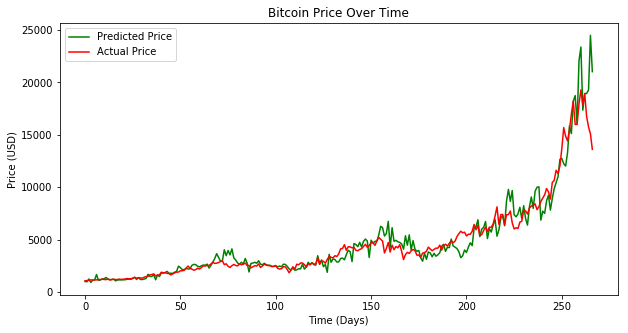

In [66]:
# Model testing with testing data
N_y_predict, y_test, y_predict, fig1 = test_model(model, N_x_test, N_y_test, unnormalized_labels)

#Show the plot
plt.show(fig1)

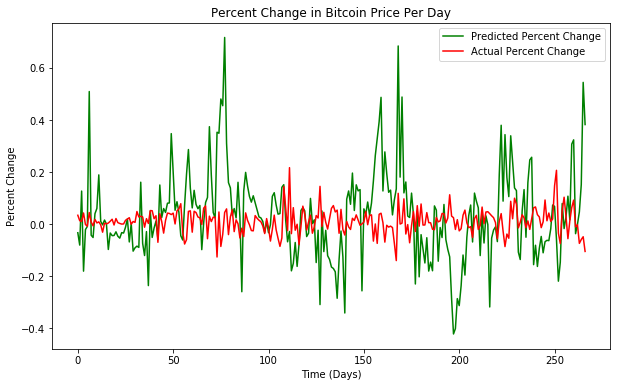

In [67]:
# To calculate how actual and predicted price changed wrt day before price of bitcoin
delta_predict, delta_test, fig2 = price_change(N_y_daybefore, N_y_test, N_y_predict)

#Show the plot
plt.show(fig2)

In [0]:
# To calculateif bitcoin predicted and actual price increase or decreases wrt day before price of bitcoin
delta_predict_binary, delta_test_binary = binary_price(delta_predict, delta_test)

#print (delta_predict_binary.shape)
#print (delta_test_binary.shape)

In [69]:
# To calculate True_pos, False_pos, True_neg and False_neg
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(delta_predict_binary, delta_test_binary)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

cm = confusion_matrix(delta_test_binary, delta_predict_binary) 
print(cm) 

True positives: 95
False positives: 58
True negatives: 41
False negatives: 73
[[41 58]
 [73 95]]


In [70]:
# Find accuracy of model

precision, recall, F1, MSE, RMSE = calculate_statistics(true_pos, false_pos, true_neg, false_neg, N_y_predict, N_y_test)
print ("Precision:", precision)
print ("Recall:", recall)
print ("F1 score:", F1)
print ("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)

Precision: 0.6209150326797386
Recall: 0.5654761904761905
F1 score: 0.5919003115264797
Mean Squared Error: 0.10014373677611672
Root Mean Squared Error: 0.31645495220665565
